# Neural Encoding Simulation Toolkit | In silico fMRI Data Tutorial

In this tutorial you will familiarize with the [Neural Encoding Simulation Toolkit (NEST)][github], consisting of trained encoding models of the brain that you can use to generate of in silico neural responses to stimuli of your choice.

For more information on NEST refer to the [documentation][documentation]. The code used to create NEST, along with its utility functions, is available on [GitHub][github].

You can run this tutorial either on [Colab][colab], or on [Jupyter Notebook][jupyter]. If you experience problems with the code, please get in touch with Ale (alessandro.gifford@gmail.com).

If you use the code and/or data from this tutorial, please cite:

> *Gifford AT, Bersch D, Roig G, Cichy RM. 2025. The Neural Encoding Simulation Toolkit. In preparation. https://github.com/gifale95/NEST*

[nest]: https://www.alegifford.com/projects/nest/
[documentation]: https://neural-encoding-simulation-toolkit.readthedocs.io/en/latest/index.html
[github]: https://github.com/gifale95/NEST
[colab]: https://colab.research.google.com/drive/1W9Sroz2Y0eTYfyhVrAJwe50GGHHAGBdE?usp=sharing
[jupyter]: https://github.com/gifale95/NEST/blob/main/tutorials/nest_fmri_tutorial.ipynb

---
---

# 0 | Configuration

Note that in sections `0.1 Install and import the necessary Python libraries` and `0.2 Access NEST` you will have to run different code cells based on whether you are running the tutorial on Colab or on Jupyter Notebook. An `if statement` will take care of this. You only need to select `'colab'` or `'jupyter_notebook'` for the `platform` variable below.

In [ ]:
# Select platform
platform = 'colab' #@param ['colab', 'jupyter_notebook']

## 0.1 | Install and import the necessary Python libraries

### 0.1.1 | Install libraries, Google Colab

If you are running the tutorial on Google Colab, you just need to install the [NEST Python package][nest_git].

[nest_git]: https://github.com/gifale95/NEST

In [ ]:
!pip install -U git+https://github.com/gifale95/NEST.git@development

### 0.1.2 | Install libraries, Jupyter Notebook

If you are running the tutorial on Jupyter Notebook, you need to install the following libraries before running the tutorial:

[h5py][h5py], [jupyter][jupyter], [matplotlib][matplotlib], [nest][nest_git], [nibabel][nibabel], [numpy][numpy], [pillow][pil], [torchvision][torchvision], [tqdm][tqdm].

[h5py]: https://docs.h5py.org/en/stable/
[jupyter]: https://jupyter.org/
[matplotlib]: https://matplotlib.org/stable/index.html
[nest_git]: https://github.com/gifale95/NEST
[nibabel]: https://nipy.org/nibabel/
[numpy]: https://numpy.org/
[pil]: https://pypi.org/project/pillow/
[torchvision]: https://pytorch.org/vision/stable/index.html
[tqdm]: https://tqdm.github.io/

### 0.1.3 | Import the libraries

Once you have installed all necessary libraries, import them with the following code.

In [ ]:
import h5py
import matplotlib
from matplotlib import pyplot as plt
from nest import NEST
import nibabel as nib
import numpy as np
import os
from PIL import Image
import torchvision
from torchvision import transforms as trn
from tqdm import tqdm
from IPython.display import display, JSON

---

## 0.2 | Access NEST

### 0.2.1 | Access NEST on Google Colab

If you are running the tutorial on Google Colab you can use NEST from the Google Drive public folder called [`neural_encoding_simulation_toolkit`][nest]. Before running the tutorial code you need to right-click on this folder, and select `Organise` → `Add shortcut`. This will create a shortcut (without copying or taking space) of the folder to a desired path in your Google Drive, from which you can read the content after mounting using `drive.mount()`. Finally, edit the `nest_dir` variable below with the path on your Drive to the `neural_encoding_simulation_toolkit` shortcut folder.

<font color='red'><b>NOTE:</b></font> **You need to manually create the data shortcut yourself, as the code cell below won't do this for you.**

[nest]: https://forms.gle/ZKxEcjBmdYL6zdrg9

In [ ]:
if platform == 'colab':
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    nest_dir = '/content/drive/MyDrive/neural_encoding_simulation_toolkit' #@param {type:"string"}

### 0.2.2 | Access NEST on Jupyter Notebook

If you are running the tutorial on Jupyter Notebook you first need to download NEST from the public Google Drive folder [`neural_encoding_simulation_toolkit`][data], and then edit the `nest_dir` variable below with the path to the downloaded and unzipped data folder.

Note that the `neural_encoding_simulation_toolkit` folder contains several GBs of data, and thus the download might take a while. However, based on your needs you might choose to download only a part of it. [NEST's documentation][documentation] provides a detailed description of NEST's content, which will help you in this choice.

We recommend downloading NEST directly from Google Drive via terminal using [Rclone][rclone]. [Here][guide] is a step-by-step guide for how to install and use Rclone to move files to and from your Google Drive. Before downloading NEST via terminal you need to add a shortcut of the `neural_encoding_simulation_toolkit` folder to your Google Drive. You can do this by right-clicking on the `neural_encoding_simulation_toolkit` folder, and selecting `Organise` → `Add shortcut`. This will create a shortcut (without copying or taking space) of the folder to a desired path in your Google Drive, from which you can download its content.

[data]: https://forms.gle/ZKxEcjBmdYL6zdrg9
[documentation]: https://neural-encoding-simulation-toolkit.readthedocs.io/en/latest/index.html
[rclone]: https://rclone.org/
[guide]: https://noisyneuron.github.io/nyu-hpc/transfer.html

In [ ]:
if platform == 'jupyter_notebook':
    nest_dir = '../neural_encoding_simulation_toolkit'

---
---

# 1 | Load and Prepare Images for Generating In-Silico Responses
The following code will load and preprocess the images that can be used to generate in-silico neural responses using one of the models you can select further below.

The encoding models expect images in a specific format: a 4D numpy array with shape (Batch size × 3 RGB Channels × Width × Height) and integer values in the range [0, 255]. The images must also be square (equal width and height), so we'll center crop them during loading.

In [78]:
images_dir = os.path.join(nest_dir, 'nest_tutorials', 'tutorial_images')
images_list = os.listdir(images_dir)
images_list.sort()

images = []
for img in tqdm(images_list):
    img_dir = os.path.join(images_dir, img)
    img = Image.open(img_dir).convert('RGB')
    # Center crop the images to square format, and resize them
    transform = trn.Compose([
        trn.CenterCrop(min(img.size)),
        trn.Resize((227,227))
    ])
    img = transform(img)
    img = np.asarray(img)
    img = img.transpose(2,0,1)
    images.append(img)
images = np.asarray(images)

# Print the images dimensions
print('\n\nImages shape:')
print(images.shape)
print('(Batch size × 3 RGB Channels x Width x Height)')

100%|██████████| 100/100 [00:01<00:00, 73.17it/s]



Images shape:
(100, 3, 227, 227)
(Batch size × 3 RGB Channels x Width x Height)


Let's visualize one of the loaded images to ensure everything looks correct:

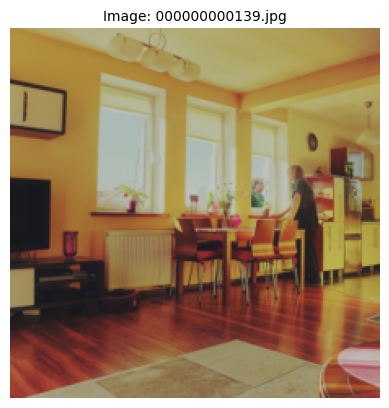

In [79]:
# Choose the image you would like to visualize
img_num = 0 # @param {type:"slider", min:0, max:99, step:1}

# Plot the image
plt.figure()
plt.axis('off')
plt.imshow(images[img_num].transpose(1,2,0))
plt.title('Image: ' + images_list[img_num], fontsize=10);

---
---
# 2 | Initialize NEST

## 2.1 | Create the NEST object

To use the NEST package, you first need to create a `NEST` object, providing the path to the Neural Encoding Simulation Toolkit directory. This object will be the instance through which you can generate in-silico brain responses.

In [80]:
# Initialize the NEST object with the path to the toolkit directory
nest = NEST(nest_dir)

## 2.2 | Browse the available encoding models

Let's explore what's available in the NEST toolkit. Each model has a unique ID with a naming pattern `modality-dataset-model`.




In [81]:
# List all available models and their versions
available_models = nest.list_models()
print(f"Available models: {available_models}")

Available models: ['fmri-nsd-fwrf', 'eeg-things_eeg_2-vit_b_32']


You can also view the modalities and datasets in a more structured format:

In [82]:
# Get a hierarchical view of available models by modality and dataset
catalog = nest.get_model_catalog(print_format=True)
print(f"Model Catalog as Dict: {catalog}")

Available Modalities and Datasets:
• EEG
  └─ things_eeg_2

• FMRI
  └─ nsd

Model Catalog as Dict: {'fMRI': ['nsd'], 'EEG': ['things_eeg_2']}


The `print_format=True` parameter displays a nicely formatted hierarchical view in the console, making it easy to browse what's available.

In [83]:
# Select one of the existing models
model_id = 'eeg-things_eeg_2-vit_b_32'  #@param ["fmri-nsd-fwrf", "eeg-things_eeg_2-vit_b_32"]

## 2.3 | Get detailed model information

NEST provides comprehensive documentation for each model via the `.describe()`function. This returns all the details you need to understand and use the model effectively:

In [84]:
# Get comprehensive information about the fMRI model
model_info = nest.describe(model_id)
print(list(model_info.keys()))

🧠 Model: eeg-things_eeg_2-vit_b_32

Modality: EEG
Training dataset: THINGS EEG2
Creator: Alessandro Gifford

📋 Description:
These encoding models consist in a linear mapping (through linear regression) of
vision transformer (Dosovitskiy et al., 2020) image features onto EEG responses.
Prior to mapping onto EEG responses, the image features have been downsampled to
250 principal components using principal component analysis.  The encoding
models were trained on THINGS EEG2 (Gifford et al., 2022), 63-channel EEG
responses of 10 subjects to over 16,740 images from the THINGS initiative
(Hebart et al., 2019).  **Preprocessing. During preprocessing the 63-channel raw
EEG data was filtered between 0.03 Hz and 100 Hz; epoched from -100 ms to +600
ms with respect to stimulus onset; transformed using current source density
transform; downsampled to 200 Hz resulting in 140 times points per epoch (one
every 5 ms); baseline corrected at each channel using the mean of the pre-
stimulus interval. No

The `describe()` function provides all the essential information needed to work with the model, including:

* **Basic Information:** Details about the modality, dataset, and features
* **Description:** How the model works and what it does
* **Input Requirements:** Format specifications for images (dimensions, type, etc.)
* **Output Format:** The structure and meaning of the model's predictions
* **Parameters:** Required and optional arguments for functions like `get_encoding_model()`
* **Performance Information:** Metrics on how well the model performs
* **Usage Examples:** Code snippets showing how to use the model

This information will help you understand how to properly set up and use the model in the following sections.

You can examine the parameters required for your specific model:

In [85]:
display(JSON(model_info["parameters"]))

<IPython.core.display.JSON object>

---
---


# 3 | The NEST Workflow: Generating In-Silico Responses

One of the key advantages of NEST is its consistent workflow across different neural modalities and models. The whole process comes down to just **two key functions**:

- `get_encoding_model()` – Load a model
- `encode()` – Generates In-Silico neural responses

These functions are model-agnostic and work across different data modalities.

## 3.1 | Loading models with get_encoding_model()
The first step is to load your chosen model using `get_encoding_model()`:

```python
# General format
model = nest.get_encoding_model(model_id, subject, **other_parameters)
```

### Key parameters:
- `model_id`: The identifier for the model (e.g., "fmri-nsd-fwrf")
- `subject`: Subject ID to simulate from (required for all models)
- `device`: Computing device ("cpu", "cuda", or "auto")
- `selection`: Optional dictionary to specify which parts of the brain to analyze

Let's load a model:


In [86]:
# Load the selected model for subject 1
model = nest.get_encoding_model(model_id,
                               subject=1,
                               device="auto")

# # Or depending on the parameters available
# model = nest.get_encoding_model(model_id,
#                                 subject=1,
#                                 selection={"roi": "V1"}, # or other
#                                 device="cpu")
# # Or even that:
# timepoint_mask = [1]*48 + [0]*92
# model = nest.get_encoding_model(model_id,
#                                 subject=1,
#                                 selection={
#                                     "channels": ["F7"],
#                                     "timepoints": timepoint_mask}
#                                 )

Model loaded on cuda for subject 1


## 3.2 | Generating in-silico responses with encode()

Once the model is loaded, you can generate simulated brain responses from your images using the `encode()` function:

```python
# Basic usage
responses = nest.encode(model, images)

# To also get metadata about the responses
responses, metadata = nest.encode(model, images, return_metadata=True)
```

With NEST the encode() works the same way regardless of which neural modality you're using. The inputs and workflow remain consistent, making it easy to switch between different types of brain data.

Let's generate some in-silico responses:

In [98]:
# Generate responses for our images
in_silico_responses = nest.encode(model, images)

Encoding fMRI responses: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s, Encoded images=100, Total images=100]


In [99]:
print(f"Response shape: {in_silico_responses.shape}")

Response shape: (100, 1350)


## 3.3 | Working with metadata
NEST provides metadata for each model, which can be accessed in two ways:

In [100]:
# Method 1: Get metadata during encoding
in_silico_responses, metadata = nest.encode(model, images, return_metadata=True)

# Method 2: Get metadata directly from the model
metadata = model.get_metadata()

Encoding fMRI responses: 100%|██████████| 1/1 [00:00<00:00,  9.01it/s, Encoded images=100, Total images=100]


In [101]:
# Let's examine the metadata
print(f"Metadata keys: {metadata.keys()}")

Metadata keys: dict_keys(['fmri', 'encoding_models'])


## 3.4 | Customizing model selection

NEST allows you to focus on specific parts of the brain by using the `selection` parameter:

---
---
# 4 | Complete Working Examples

## Example 1: fMRI analysis of visual cortex

In [102]:
#@title Select subject and ROI for fMRI model
subject = 1  #@param {type:"slider", min:1, max:8, step:1}
roi = "V1"  #@param ["V1", "V2", "V3", "hV4", "EBA", "FBA-2", "OFA", "FFA-1", "FFA-2", "PPA", "RSC", "OPA", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "early", "midventral", "midlateral", "midparietal", "parietal", "lateral", "ventral"]


In [103]:
# Initialize NEST
from nest import NEST
nest = NEST(nest_dir)

# Load model for the selected ROI and subject
model = nest.get_encoding_model("fmri-nsd-fwrf",
                                subject=subject,
                                selection={"roi": roi})

# Generate in-silico fMRI responses
responses = nest.encode(model, images)
print(f"{roi} responses shape: {responses.shape}")


Model loaded on cuda for subject 1, ROI V1


Encoding fMRI responses: 100%|██████████| 1/1 [00:00<00:00, 10.18it/s, Encoded images=100, Total images=100]

V1 responses shape: (100, 1350)


## Example 2: EEG with channel and time selection

In [110]:
#@title Select EEG subject and channels

#@markdown Select Subject
subject = 1  #@param {type:"slider", min:1, max:10, step:1}

#@markdown Enter the list of EEG channels to include
# ['Fp1', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9',
# 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8',
# 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2',
# 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3',
# 'FCz', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz',
# 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4',
# 'FT8', 'F6', 'F2', 'AF4', 'AF8']

channels = ['F7', 'F3', 'F4', 'F8']  #@param {type:"raw"}

#@markdown Set time window (between 0 and 140 timepoints)
start_timepoint = 0  #@param {type:"slider", min:0, max:139, step:1}
end_timepoint = 140  #@param {type:"slider", min:1, max:140, step:1}

# Create timepoint mask from start and end selection
timepoint_mask = [1 if start_timepoint <= i < end_timepoint else 0 for i in range(140)]


In [111]:
from nest import NEST

# Initialize NEST
nest = NEST(nest_dir)

# Load EEG model
eeg_model = nest.get_encoding_model("eeg-things_eeg_2-vit_b_32",
                                    subject=subject,
                                    selection={
                                        "channels": channels,
                                        "timepoints": timepoint_mask
                                    })

# Generate responses
frontal_responses = nest.encode(eeg_model, images)

# Print results cleanly (on a new line after tqdm)
import sys; sys.stdout.write("\n")
print(f"EEG response shape: {frontal_responses.shape}")

# Show metadata
metadata = eeg_model.get_metadata()
print(metadata.keys())

Model loaded on cuda for subject 1


Encoding EEG responses: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it, Encoded images=100, Total images=100]


EEG response shape: (100, 4, 4, 140)
dict_keys(['eeg', 'encoding_models'])
